<a href="https://colab.research.google.com/github/mantzaris/teddyCode/blob/main/Graphical_NN_10_15_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.7.1 on the current Colab Runtime...
2022-10-15 16:20:47 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.1-linux-x86_64.tar.gz [123374573/123374573] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package Plots...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.7

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# New Section

# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [2]:
import Pkg; Pkg.add("InvertedIndices")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed InvertedIndices ─ v1.1.0
    Updating `~/.julia/environments/v1.7/Project.toml`
  [41ab1584] + InvertedIndices v1.1.0
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [41ab1584] + InvertedIndices v1.1.0
Precompiling project...
  ✓ InvertedIndices
  1 dependency successfully precompiled in 2 seconds (142 already precompiled)


In [3]:
using Plots
using LinearAlgebra
using BenchmarkTools
import Random
using InvertedIndices

In [72]:
using InvertedIndices
using Plots 
using LinearAlgebra
using BenchmarkTools
import Random

function make_mtrx(dimentions, list_1, list_2)
  m = zeros(dimentions, dimentions)
  for i in list_1
    for j in list_2
      m[i, j] = 1
    end
  end
  return m
end


function get_zeros_non_zeros(mtrx, x_dim, y_dim)
  s = 0
    for i in range(1, x_dim)
      for j in range(1, y_dim)
        if (a[i, j] == 0.0)
          s = s + 1
        end
      end
    end
    println("Zeros: $s and Non-zeros: ", x_dim * y_dim - s)
  return s
end

function random_matrix(a, b, x_dim, y_dim)
  Random.seed!(1234)
  mtrx = rand(a:b, x_dim, y_dim )
  print(mtrx)
  return mtrx
end

function get_each_element(mtrx, x_dim, y_dim)
  for i in range(1, x_dim)
    for j in range(1, y_dim)
     print("mtrx[$i, $j]  = ", mtrx[i, j], "\n")
    end
  end
end

function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

function initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  print("\n")
  println("Making a matrix, this might take some time...")
  a = random_matrix(a_down_lim, a_up_lim, a_dim, a_dim)
  print("\n")
  println("Calculating aj matrix, this might take some time...")
  aj = A2S(a)
  print("\n")
  println("Making x matrix, this might take some time...")
  x = random_matrix(x_down_lim, x_up_lim, a_dim, x_y_dim)
  print("\n")
  println("Making th matrix, this might take some time...")
  th = random_matrix(th_down_lim, th_up_lim, x_y_dim, th_y_dim)
  print("\n")
  println("Calculating final matrix, final = aj * x * th ")
  Final = aj * x * th  
  return a, aj, x, th, Final
end



function reduce_size(a, x, th, n_col_row_to_reduce)
  x_dim = size(a, 1)
  y_dim = size(a, 2)
  a_reduced = a[Not(x_dim - n_col_row_to_reduce: end), Not(y_dim - n_col_row_to_reduce : end)]
  aj_reduced = A2S(a_reduced)
  x_reduced = x[Not(x_dim - n_col_row_to_reduce: end), :]
  Final_reduced = aj_reduced * x_reduced * th
  return Final_reduced
  end


function mae(mtrx, mtrx_reduced)
  x = size(mtrx_reduced, 1)
  y = size(mtrx_reduced, 2)
  s = 0
  for i in range(1, x)
    for j in range(1, y)
      s = s + abs(mtrx[i, j] - mtrx_reduced[i, j])
    end
  end
  mae = sqrt(s/(x*y))
  return mae 
  end
  


function total_error(n_drop_row_col, a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim )
  mean_average_error = Vector{Float64}()
  a, aj, x, th, Final = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  for i in range(-1, n_drop_row_col)
    F1 = reduce_size(a, x, th, i)
    MAE = mae(Final, F1)
    append!(mean_average_error,MAE)
  end
  skip = collect(-1: n_drop_row_col)
  return(mean_average_error, skip)
  end

 function split_alpha_matrix(a_mtrx, n_lines_to_split)
  x = size(a_mtrx, 1)
  y = size(a_mtrx, 2)
  n = div(x, n_lines_to_split)
  dictionary = Dict()
  count = 1
  k = 1
  for i in range(1, n_lines_to_split)
    z = 1
    for j in range(1, n_lines_to_split)
      dictionary["a_$count"] = a_mtrx[k: k + n - 1, z: j*n ]
      count = count + 1
      z = z + n
    end
    k = k + n
  end
  #show(stdout, "text/plain", dictionary["a_1"])
  return(dictionary)
end


function split_x_matrix(x_mtrx, n_lines_to_split)
  x = size(x_mtrx, 1)
  n = div(x, n_lines_to_split)
  print(n)
  dictionary = Dict()
  z = 1
  for i in range(1, n_lines_to_split)
    dictionary["x_$i"] = x_mtrx[z : z + n - 1 , 1:end]
    z = z + n
  end
  #show(stdout, "text/plain", dictionary["x_3"])
  return(dictionary)
  end 

 function dictionary_to_matrix(dict, x_splited_length, x_y_dim, x_mtrx, n_lines_to_split)
  i = 1 
  mtrx_reduced_dictionary = Dict()
  count = 1
  num = div(size(x_mtrx, 1), n_lines_to_split)
  while (i <= length(dict)) 
    s = zeros(num, x_y_dim)
    k = 1 
    while k <= x_splited_length  
      s = s + dict["aj_x_$i"] 
      k = k + 1 
      i = i + 1
    end 
  mtrx_reduced_dictionary["A_$count"] = s
  count = count + 1
  end 
  s_ = vcat(mtrx_reduced_dictionary["A_1"])
  for i in range(2, length(mtrx_reduced_dictionary))
    aux = vcat(s_, mtrx_reduced_dictionary["A_$i"])
    s_ = aux
  end
  return s_ 
end 


function multiply_splited(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim, n_lines_to_split)
  a_mtrx,  aj_mtrx, x_mtrx, th_mtrx, final_mtrx  = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  a_splited = split_alpha_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  aj_splited = Dict()
  print("\n")
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  #show(stdout, "text/plain", aj_splited)
  aj_x = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      aj_x["aj_x_$k"] = aj_splited["aj_$k"] * x_splited["x_$i"] 
      k = k + 1
    end
  end
  aj_x_mtrx = dictionary_to_matrix(aj_x, length(x_splited), x_y_dim, x_mtrx, n_lines_to_split)
  final = aj_x_mtrx * th_mtrx
  #show(stdout, "text/plain", final)
  return(final)
end


function multiply_splited_2(a_mtrx, x_mtrx, th_mtrx, n_lines_to_split)
  a_splited = split_alpha_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  x_y_dim = size(x_mtrx, 2)
  aj_splited = Dict()
  print("\n")
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  #show(stdout, "text/plain", aj_splited)
  aj_x = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      aj_x["aj_x_$k"] = aj_splited["aj_$k"] * x_splited["x_$i"] 
      k = k + 1
    end
  end
  aj_x_mtrx = dictionary_to_matrix(aj_x, length(x_splited), x_y_dim, x_mtrx, n_lines_to_split)
  final = aj_x_mtrx * th_mtrx
  #show(stdout, "text/plain", final)
  return(final)
end

multiply_splited_2 (generic function with 2 methods)

In [67]:
error_, skip_ = total_error(200, 1000, 0, 10, 10, -4, 4, 5, -2, 2)


Making a matrix, this might take some time...
[3 1 8 3 6 8 1 4 10 1 6 3 5 6 10 5 9 3 6 6 5 2 10 10 10 4 4 6 2 8 8 5 10 7 0 8 6 3 9 7 6 7 0 10 1 7 5 7 9 9 1 5 7 6 5 10 2 4 10 10 7 1 0 4 10 1 8 3 5 0 10 2 5 8 8 5 5 6 1 10 5 5 4 3 8 5 0 7 7 3 1 0 8 6 10 8 5 3 0 2 1 2 6 8 6 10 7 2 8 8 6 7 10 0 6 9 3 0 1 8 0 8 2 5 9 9 8 10 7 6 4 0 9 3 6 7 5 9 8 8 7 7 0 10 7 10 9 3 7 3 7 7 3 9 10 9 6 10 8 4 9 7 2 5 5 7 4 3 1 1 0 2 9 0 6 6 9 3 3 8 0 7 3 5 10 7 10 0 3 8 7 2 4 7 10 10 3 6 6 2 8 7 1 6 9 3 1 1 4 5 10 5 7 8 9 3 6 0 0 2 10 6 3 9 0 1 3 3 0 6 9 4 6 2 3 6 0 10 4 6 3 5 6 3 0 3 1 4 4 1 1 8 5 1 3 9 10 0 6 8 9 10 4 6 2 10 2 10 7 0 1 6 0 7 4 10 1 2 10 10 0 1 7 6 4 1 0 0 8 6 5 5 7 4 1 10 3 9 6 8 1 5 0 10 3 7 10 10 3 4 0 10 6 1 4 10 5 6 9 6 4 9 2 0 7 6 10 7 6 10 0 6 9 3 6 2 10 6 7 2 6 4 0 1 3 3 3 4 5 9 7 7 2 0 1 2 9 2 3 1 7 6 0 3 9 5 0 1 3 7 10 9 3 3 4 3 9 10 2 1 8 1 10 4 8 5 8 6 10 7 3 2 7 9 7 1 6 4 0 5 0 9 10 0 2 9 4 9 7 10 9 10 1 3 4 6 7 7 4 2 8 2 8 7 7 8 6 3 9 1 10 0 3 0 0 1 5 3 9 7 4 4 3 8 6 7 6 6 10 5

Excessive output truncated after 524289 bytes.

 2 10 0 5 1 5 2 3 4 9 6 0 9 5 3 3 8 8 6 7 5 4 6 2 6 0 0 8 4 7 0 6 3 1 3 5 9 3 2 9 0 0 9 6 3 1 0 7 8 6 3 2 5 0 6 10 7 3 1 7 3 4 6 9 5 4 0 3 7 5 0 4 1 9 2 3 0 5 6 4 6 0 4 1 5 3 6 8 9 2 6 9 10 10 5 3 3 5 2 5 3 5 8 8 3 0 4 3 7 2 1 8 6 5 5 4 9 0 3 8 3 9 1 4 3 0 6 0 2 4 9 8 2 8 2 4 10 0 2 4 4 1 4 10 0 3 9 9 10 7 8 4 10 2 2 9 0 1 10 0 5 7 3 4 9 2 9 9 6 10 0 2 6 10 3 6 5 8 3 3 10 7 8 6 0 1 10 7 1 7 10 5 9 7 5 9 2 2 0 6 6 7 2 5 6 2 2 6 3 8 4 8 4 2 0 9 2 0 1 5 7 5 0 3 4 0 10 3 8 6 0 0 1 9 2 5 0 10 4 6 8 0 7 0 10 9 6 10 1 3 7 7 1 6 10 4 7 10 0 8 1 7 1 7 1 2 7 4 1 7 6 3 0 4 8 1 6 1 10 1 8 10 10 10 1 5 10 2 9 7 8 2 3 5 4 1 7 10 9 3 2 6 3 2 3 10 6 4 3 0 10 0 3 1 8 5 10 1 4 0 1 3 8 8 4 9 10 7 0 4 5 1 6 6 8 9 6 4 0 3 7 6 1 10 10 6 0 2 6 5 7 4 1 7 9 6 7 10 1 4 0 4 10 1 9 7 5 6 10 9 8 0 4 0 10 9 1 3 1 8 8 5 3 9 6 7 4 10 4 2 9 9 0 0 1; 8 3 1 10 0 8 4 5 5 2 10 2 9 6 7 8 9 7 0 0 1 8 1 10 10 7 7 7 8 6 6 0 0 1 10 2 8 10 8 8 3 10 0 0 7 9 10 10 6 10 9 3 8 2 10 9 10 5 6 3 0 6 2 0 8 7 6 1 4 8 5 5 5 4 10 2 4 3 8 

([0.0, 0.10594499766239739, 0.1173107248859289, 0.14202154180709572, 0.1358479348647049, 0.14726058983737897, 0.13906124155115432, 0.14187862573928126, 0.1361848262913093, 0.1401387038229103  …  0.38683797706084155, 0.3907135393355173, 0.39597999643022636, 0.39063776214848234, 0.38371681401762775, 0.38685943835573805, 0.3846243538095439, 0.37771464573481117, 0.38703597104659926, 0.3803390026516193], [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200])

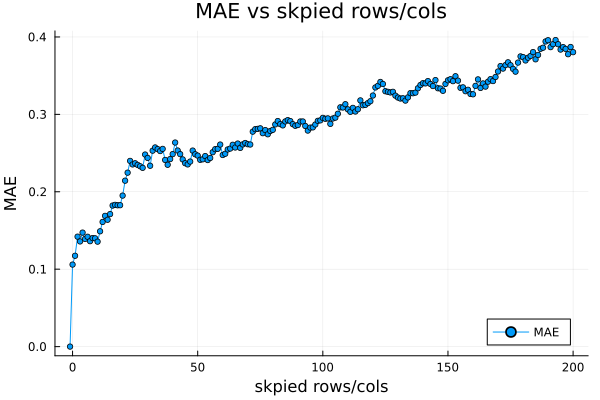

In [68]:
plot(skip_, # x-axis
    error_, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs skpied rows/cols",
    xlabel = "skpied rows/cols",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

In [77]:
a, aj, x, th, final = initial_matrix(10000, 0, 150, 20, -4, 4, 5, -2, 2)

final


Making a matrix, this might take some time...
[49 85 79 115 89 26 97 144 77 24 16 89 13 66 101 109 124 12 9 97 112 150 145 135 42 13 130 21 12 81 17 4 61 4 91 99 103 139 121 41 7 124 116 147 61 101 109 79 3 55 106 84 111 54 65 60 148 11 127 10 88 148 50 120 115 127 91 30 63 90 19 77 80 2 140 18 72 85 28 131 146 28 14 35 138 131 50 18 14 0 55 61 99 71 96 141 107 107 68 108 41 64 127 38 126 23 122 129 96 19 106 33 119 16 125 4 23 14 141 40 42 113 44 105 139 123 9 40 19 85 108 124 45 45 137 97 134 1 101 109 44 90 84 91 69 110 16 139 79 54 90 64 70 126 37 24 107 10 63 128 108 55 73 58 77 34 10 3 134 80 4 38 40 61 122 8 46 56 84 140 106 12 57 144 112 128 110 105 41 13 9 52 137 143 70 45 0 140 0 125 58 63 74 77 150 123 127 41 2 46 56 11 108 61 21 27 110 135 112 31 88 10 82 26 115 117 142 32 102 60 26 85 135 134 103 116 116 84 60 93 40 8 19 57 36 59 53 130 84 113 100 76 138 27 112 110 143 94 121 129 22 37 121 74 95 133 135 54 36 70 118 48 37 51 12 30 81 116 110 47 15 17 13 104 21 64 19 3 10 

Excessive output truncated after 524290 bytes.

 11 32 13 149 41 70 20 120 88 32 31 28 102 17 121 12 57 26 59 7 123 119 90 53 104 87 95 19 125 111 19 96 24 0 73 111 103 117 11 148 5 93 116 79 29 129 105 91 122 22 104 146 69 4 2 41 125 127 146 31 135 20 38 71 118 114 43 138 5 93 141 112 104 95 71 77 47 71 76 2 83 63 142 51 6 68 116 100 65 31 57 81 61 134 38 141 115 79 78 41 16 79 134 5 73 123 67 75 129 28 101 31 11 66 80 38 14 85 54 31 33 87 123 34 48 70 99 34 140 134 20 119 79 82 112 0 54 85 112 82 42 114 58 17 62 55 86 54 40 105 102 149 116 36 145 96 7 96 112 47 89 74 71 134 23 112 23 127 52 144 43 62 38 150 149 83 41 126 69 43 106 94 76 111 108 31 81 67 87 118 3 67 67 14 94 116 73 142 60 113 44 127 50 15 47 40 137 72 0 47 20 72 19 81 124 115 112 118 9 10 14 4 47 136 98 70 40 101 85 85 33 2 33 85 130 30 139 23 0 21 94 122 136 54 65 107 128 56 123 7 142 57 2 101 39 37 64 133 124 123 100 52 10 34 48 84 119 17 60 120 139 88 23 0 75 143 78 8 80 147 99 51 90 125 148 36 67 87 126 139 94 109 70 85 88 0 3 150 8 30 136 94 63 57 141 47 68 15

10000×5 Matrix{Float64}:
 0.267209     0.0880954  -0.0153049    0.0746314   0.0705138
 0.072034     0.0311853  -0.110914     0.108432   -0.0722211
 0.011223    -0.0135334   0.0789222    0.218436   -0.248625
 0.0781609    0.0481187   0.234803    -0.196092   -0.0759411
 0.161875    -0.0509328   0.052734     0.123915   -0.0634105
 0.266593    -0.10094    -0.00793948   0.181084   -0.0898963
 0.355553    -0.134799    0.103267     0.082863   -0.20518
 0.145166     0.122191    0.132017     0.182907   -0.22859
 0.121772     0.131613    0.138481     0.0733555  -0.0565716
 0.0616373    0.0847794   0.183619    -0.0191111  -0.127722
 0.0843782   -0.0311122   0.0901719    0.0274827  -0.040358
 0.00879723  -0.0127465   0.028472    -0.124153   -0.097895
 0.0891156    0.0221034   0.0909661    0.0276129  -0.132476
 ⋮                                                
 0.187703     0.198708    0.11273     -0.0571238   0.0469241
 0.13042     -0.0945133  -0.136953     0.268146   -0.26686
 0.0771889    0.0680

In [78]:
f = multiply_splited_2(a, x, th, 1)

10000


10000×5 Matrix{Float64}:
 0.267209     0.0880954  -0.0153049    0.0746314   0.0705138
 0.072034     0.0311853  -0.110914     0.108432   -0.0722211
 0.011223    -0.0135334   0.0789222    0.218436   -0.248625
 0.0781609    0.0481187   0.234803    -0.196092   -0.0759411
 0.161875    -0.0509328   0.052734     0.123915   -0.0634105
 0.266593    -0.10094    -0.00793948   0.181084   -0.0898963
 0.355553    -0.134799    0.103267     0.082863   -0.20518
 0.145166     0.122191    0.132017     0.182907   -0.22859
 0.121772     0.131613    0.138481     0.0733555  -0.0565716
 0.0616373    0.0847794   0.183619    -0.0191111  -0.127722
 0.0843782   -0.0311122   0.0901719    0.0274827  -0.040358
 0.00879723  -0.0127465   0.028472    -0.124153   -0.097895
 0.0891156    0.0221034   0.0909661    0.0276129  -0.132476
 ⋮                                                
 0.187703     0.198708    0.11273     -0.0571238   0.0469241
 0.13042     -0.0945133  -0.136953     0.268146   -0.26686
 0.0771889    0.0680

In [79]:
mae_splited = Vector{Float64}()
dim = 1000
for i in range(1, 100)
  println("--- $i ---")
  f = multiply_splited_2(a, x, th, i)
  mae_spl = mae(final, f)
  append!(mae_splited, mae_spl)
  end

--- 1 ---
10000
--- 2 ---
5000
--- 3 ---
3333
--- 4 ---
2500
--- 5 ---
2000
--- 6 ---
1666
--- 7 ---
1428
--- 8 ---
1250
--- 9 ---
1111
--- 10 ---
1000
--- 11 ---
909
--- 12 ---
833
--- 13 ---
769
--- 14 ---
714
--- 15 ---
666
--- 16 ---
625
--- 17 ---
588
--- 18 ---
555
--- 19 ---
526
--- 20 ---
500
--- 21 ---
476
--- 22 ---
454
--- 23 ---
434
--- 24 ---
416
--- 25 ---
400
--- 26 ---
384
--- 27 ---
370
--- 28 ---
357
--- 29 ---
344
--- 30 ---
333
--- 31 ---
322
--- 32 ---
312
--- 33 ---
303
--- 34 ---
294
--- 35 ---
285
--- 36 ---
277
--- 37 ---
270
--- 38 ---
263
--- 39 ---
256
--- 40 ---
250
--- 41 ---
243
--- 42 ---
238
--- 43 ---
232
--- 44 ---
227
--- 45 ---
222
--- 46 ---
217
--- 47 ---
212
--- 48 ---
208
--- 49 ---
204
--- 50 ---
200
--- 51 ---
196
--- 52 ---
192
--- 53 ---
188
--- 54 ---
185
--- 55 ---
181
--- 56 ---
178
--- 57 ---
175
--- 58 ---
172
--- 59 ---
169
--- 60 ---
166
--- 61 ---
163
--- 62 ---
161
--- 63 ---
158
--- 64 ---
156
--- 65 ---
153
--- 66 ---
151
--- 67 -

In [82]:
println(length(mae_splited))
counter = 1
counter_list = Vector{Float64}()
for i in mae_splited
  println("$counter, $i")
  append!(counter_list, counter)
  counter = counter + 1
end

100
1, 1.0195967051035742e-8
2, 0.3165350097042863
3, 0.44634690015072004
4, 0.5481721468694236
5, 0.6334991730142503
6, 0.7059898017507377
7, 0.7742911090013914
8, 0.8366856173582257
9, 0.8928072928061441
10, 0.9500006445632835
11, 0.9975612535218223
12, 1.0482327572881764
13, 1.095729917936345
14, 1.1396973355165048
15, 1.1809508963152755
16, 1.2258170397344903
17, 1.2636939687885314
18, 1.3033899266610511
19, 1.3393188578640496
20, 1.3804030580502127
21, 1.413244278389393
22, 1.4548499185163069
23, 1.5003379424807548
24, 1.5339124445409569
25, 1.5516646722821354
26, 1.599575612256172
27, 1.6128922980884632
28, 1.643038092906552
29, 1.685699616664364
30, 1.7016192619448893
31, 1.7522820364130274
32, 1.780757486679957
33, 1.786294311317101
34, 1.816956579886039
35, 1.8534587490687935
36, 1.8755455325239694
37, 1.8974208060284687
38, 1.9229221887273613
39, 1.9728861375955276
40, 1.9758072831641766
41, 2.000605450030986
42, 2.0227012874800065
43, 2.0678961480434284
44, 2.082378370603874

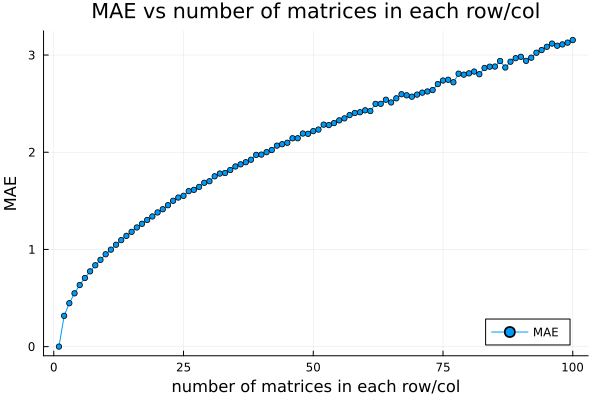

In [83]:
plot(counter_list, # x-axis
    mae_splited, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs number of matrices in each row/col",
    xlabel = "number of matrices in each row/col",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />